In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import pi, isnan, isinf
from scipy.optimize import minimize
from scipy.linalg import inv
from scipy import stats

In [2]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('../data/cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('../data/EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('../data/natgas_futures_price.csv', sep=',')

In [3]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)
# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))
# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

# Futures prices
natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%d/%m/%y')
natgas_futures.set_index('Date', inplace=True)
natgas_futures['daily_return'] = natgas_futures['natgas_future_price'].pct_change()

# Consolidating the three data series into single dataframe 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )

data.index = natgas_futures.index
data.dropna(inplace = True)
data

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
1994-01-14,2.268,0.033728,1994-01,56.733087,22
1994-01-17,2.360,0.040564,1994-01,56.733087,22
1994-01-18,2.318,-0.017797,1994-01,56.733087,22
1994-01-19,2.252,-0.028473,1994-01,56.733087,22
1994-01-20,2.250,-0.000888,1994-01,56.733087,22
...,...,...,...,...,...
2023-12-22,2.610,0.014774,2023-12,240.119738,23
2023-12-26,2.550,-0.022989,2023-12,240.119738,23
2023-12-27,2.619,0.027059,2023-12,240.119738,23


In [4]:
# Realized variance
natgas_futures_rv =\
(
    data[['daily_return']]
    .resample('M')
    .agg(lambda x: (x ** 2).sum())
    .rename(columns = {'daily_return' : 'realized_variance'})
)

natgas_futures_rv 

,realized_variance
Date,
1994-01-31,0.023208
1994-02-28,0.018283
1994-03-31,0.009809
1994-04-30,0.006717
1994-05-31,0.007172
...,...
2023-08-31,0.031140
2023-09-30,0.022613
2023-10-31,0.027795


In [5]:
for i in range(1,36):
    natgas_futures_rv[f'rv_lag_{str(i).zfill(2)}'] =\
        natgas_futures_rv['realized_variance'].shift(i)
    
natgas_futures_rv.dropna(inplace = True)
natgas_futures_rv['YYYY-MM'] = natgas_futures_rv.index.to_period('M')
natgas_futures_rv

,realized_variance,rv_lag_01,rv_lag_02,rv_lag_03,rv_lag_04,rv_lag_05,rv_lag_06,rv_lag_07,rv_lag_08,rv_lag_09,...,rv_lag_27,rv_lag_28,rv_lag_29,rv_lag_30,rv_lag_31,rv_lag_32,rv_lag_33,rv_lag_34,rv_lag_35,YYYY-MM
Date,,,,,,,,,,,,,,,,,,,,,
1996-12-31,0.135413,0.053382,0.029926,0.041352,0.022008,0.040023,0.006114,0.005021,0.006418,0.057117,...,0.059202,0.029743,0.007716,0.018509,0.007172,0.006717,0.009809,0.018283,0.023208,1996-12
1997-01-31,0.097981,0.135413,0.053382,0.029926,0.041352,0.022008,0.040023,0.006114,0.005021,0.006418,...,0.034236,0.059202,0.029743,0.007716,0.018509,0.007172,0.006717,0.009809,0.018283,1997-01
1997-02-28,0.033232,0.097981,0.135413,0.053382,0.029926,0.041352,0.022008,0.040023,0.006114,0.005021,...,0.030960,0.034236,0.059202,0.029743,0.007716,0.018509,0.007172,0.006717,0.009809,1997-02
1997-03-31,0.015613,0.033232,0.097981,0.135413,0.053382,0.029926,0.041352,0.022008,0.040023,0.006114,...,0.030791,0.030960,0.034236,0.059202,0.029743,0.007716,0.018509,0.007172,0.006717,1997-03
1997-04-30,0.008348,0.015613,0.033232,0.097981,0.135413,0.053382,0.029926,0.041352,0.022008,0.040023,...,0.024634,0.030791,0.030960,0.034236,0.059202,0.029743,0.007716,0.018509,0.007172,1997-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.031140,0.020639,0.028938,0.038353,0.052515,0.072886,0.058782,0.086368,0.085231,0.081925,...,0.005370,0.007816,0.008471,0.028731,0.018452,0.041124,0.023513,0.036742,0.112893,2023-08
2023-09-30,0.022613,0.031140,0.020639,0.028938,0.038353,0.052515,0.072886,0.058782,0.086368,0.085231,...,0.009756,0.005370,0.007816,0.008471,0.028731,0.018452,0.041124,0.023513,0.036742,2023-09
2023-10-31,0.027795,0.022613,0.031140,0.020639,0.028938,0.038353,0.052515,0.072886,0.058782,0.086368,...,0.007369,0.009756,0.005370,0.007816,0.008471,0.028731,0.018452,0.041124,0.023513,2023-10


In [6]:
rv = np.array(natgas_futures_rv.iloc[:,0])
X =\
(
    np.array(
        data[['YYYY-MM']]
        .merge(natgas_futures_rv,
               how = 'left',
               on = 'YYYY-MM')
        .dropna()
        .iloc[:,2:]
    )
)

---

### GARCH-MIDAS

Key points:
- Model uses mean-reverting unit daily GARCH process to fit the short-lived component (fast) of the volatility; MIDAS polynomial to depict the secular component driven by some lower frequency variables (slow)


$$r_{i,t} = \mu + \sqrt{\tau_ig_{i,t}}\epsilon_{i,t}, \forall i = 1, 2, ..., N_t$$

whereby
- $r_{i,t}$: price return (log or compound return?)
- $\mu$: mean daily return conditional on information set $\Psi_{i-1}$ 
- $N_t$: number of days in month t
- $g_{i,t}$: short-term component of the conditional probability
- $\tau_t$: secular component


Garch(1,1) process:
$$g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i-1,t}-\mu)^2}{\tau_t} + \beta g_{i-1,t}$$


MIDAS regression:
$$log(\tau_t) = m + \underbrace{\theta_R \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

where:
- $RV_t$: realized volatility of daily returns in month $t$
- $K_r$: number of periods over which the realized volatility is smoothed
- $\theta$: measures the contribution of RV to the secular component


Original Study:
- In-sample estimation: January 1, 1991 - December 31, 2021
- Out-sample test: January 1, 2022 - July 29, 2022
- Forecasts in this study were conducted with a rolling-window approach—i.e., using data from January 1, 1991, to December 31,
2021, to project the price volatility on January 1, 2022; using data from January 2, 1991, to January 1, 2022, to project the volatility
on January 2, 2022; and so on.

Further reference:
https://github.com/blake-marsh/GARCH_replication

In [7]:
# params : [mu, theta, omega_2, alpha, beta, m]
def beta_lag_wt_scheme(K, omega_2, omega_1 = 1):
    j_vec = np.arange(1,K)[::-1]
    denom =\
    (
        np
        .sum(
            (j_vec/K) ** (omega_1 - 1.0)
            * (1.0 - j_vec/K) ** (omega_2 - 1.0)
        )
    )

    numer =\
    (
        (j_vec/K) ** (omega_1 - 1.0)
        * (1.0 - j_vec/K) ** (omega_2 - 1.0)
    )

    return (numer / denom).reshape(j_vec.shape[0],1)
    

def GARCH_MIDAS(params, returns, X, K, full_output = False):
    mu, alpha, beta, theta, omega, m = params

    # tau
    log_tau = m + theta * np.dot(X, beta_lag_wt_scheme(K, omega))
    tau = np.exp(log_tau)
    T = tau.size

    ## define the squared errors
    e = returns[-tau.shape[0]:] - mu
    e2 = e**2

    # define g
    gt = np.array([tau[0]])

    #return e2, tau

    for t in range(1, tau.size):
        
        gt =\
            np.append(gt, 
                      (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
    
    gt = gt.reshape(-1,1)
    ht = np.multiply(tau,gt)

    # log likelihood
    logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))
    
    if isnan(logliks.sum()) or isinf(logliks.sum()):
        loglik = 1E10
    else:
        loglik = logliks.sum()

    #print loglik
    
    if full_output == True:
        return -loglik, logliks, e, tau, gt, ht, T

    else:
        return loglik



In [24]:
## initial values
x0 = np.array([0.0005, 0.09, 0.90, 1, 1, -2])

returns = np.array(data[['daily_return']])

# method='L-BFGS-B', \
results = minimize(GARCH_MIDAS, x0=x0,\
                  args = (returns, X, 36, False)) ## Limited Memory BFGS

C:\Users\leeca\AppData\Local\Temp\ipykernel_16032\3477597579.py:43: RuntimeWarning: overflow encountered in scalar multiply
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
C:\Users\leeca\AppData\Local\Temp\ipykernel_16032\3477597579.py:49: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


In [25]:
results

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -13519.791973004336
        x: [ 8.724e-04  9.195e-02  9.079e-01  1.278e+01  9.632e+00
            -2.784e+00]
      nit: 28
      jac: [-4.150e-02  1.771e+01  1.765e+01  6.104e-04 -2.441e-04
             4.639e-03]
 hess_inv: [[ 1.210e-07  5.911e-08 ... -2.326e-06  2.508e-07]
            [ 5.911e-08  4.617e-05 ...  3.353e-04  1.839e-04]
            ...
            [-2.326e-06  3.353e-04 ...  2.966e+00  2.016e-01]
            [ 2.508e-07  1.839e-04 ...  2.016e-01  7.122e-02]]
     nfev: 698
     njev: 98

In [26]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results['x'], returns, X, 36, full_output=True)

In [27]:
def gradient(GARCH_MIDAS, k, epsilon=1.49e-8):
    
    loglik, logliks, e, tau, gt, ht, T =GARCH_MIDAS(results['x'], returns, X, 36, True)
    
    step = logliks*epsilon
    scores = np.zeros((T, k))

    for i in range(k):

        h = step[i]
        delta = np.zeros(k)
        delta[i] = h
        loglik, logliksplus, e, tau, gt, ht, T =GARCH_MIDAS(results['x'] + delta, returns, X, 36, full_output=True)
        loglik, logliksminus, e, tau, gt, ht, T = GARCH_MIDAS(results['x'] - delta, returns, X, 36, full_output=True)
        scores[:,i] = ((logliksplus - logliksminus)/(2*h)).flatten()

    return scores


#-----------------------------
# 2-sided Hessian function
# from Sheppard (2014)
#------------------------------
def hessian_2sided(fun, theta, args, epsilon=1e-05):
    f = fun(theta, *args)
    h = epsilon*np.abs(theta)
    thetah = theta + h
    h = thetah - theta
    K = np.size(theta,0)
    h = np.diag(h)
    
    fp = np.zeros(K)
    fm = np.zeros(K)
    for i in range(K):
        fp[i] = fun(theta+h[i], *args)
        fm[i] = fun(theta-h[i], *args)
        
    fpp = np.zeros((K,K))
    fmm = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j],  *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(theta - h[i] - h[j],  *args)
            fmm[j,i] = fmm[i,j]
            
    hh = (np.diag(h))
    hh = hh.reshape((K,1))
    hh = np.dot(hh,hh.T)
    
    H = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f 
                       + f - fm[i] - fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    
    return H

In [28]:
scores = gradient(GARCH_MIDAS, results['x'].size)
H = hessian_2sided(GARCH_MIDAS, results['x'], (returns, X, 36, False))

In [29]:

# outer product of gradient standard errors
OPG = np.dot(scores.T,scores)/T
vcv_opg = inv(OPG)/T
se_opg = np.diag(vcv_opg)**0.5
t_opg = results['x']/se_opg

# second derivatives
## Note: Inverse Hessian as used by RGS in the matlab code
vcv_H = inv(H/T)/T
se_H = np.diag(vcv_H)**0.5
t_H = results['x']/se_H
pvalues_H = stats.t.sf(np.abs(t_H),data.size-len(results['x']))

# sandwich form (Bollerslev-Wooldrige)
vcv_bw = np.dot(inv(H/T), np.dot(OPG,inv(H/T)))/T
se_bw = np.diag(vcv_bw)**0.5
t_bw = results['x']/se_bw
pvalues_bw = stats.t.sf(np.abs(t_bw),data.size-len(results['x']))

C:\Users\leeca\AppData\Local\Temp\ipykernel_16032\969985697.py:10: RuntimeWarning: invalid value encountered in sqrt
  se_H = np.diag(vcv_H)**0.5


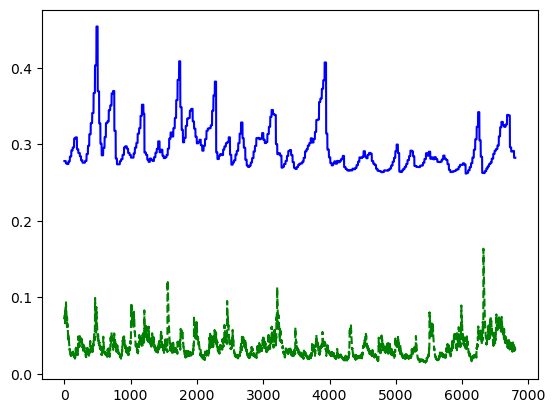

In [30]:
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()